<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Exercise-1:" data-toc-modified-id="Exercise-1:-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Exercise 1:</a></span></li><li><span><a href="#Exercise-2:" data-toc-modified-id="Exercise-2:-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Exercise 2:</a></span><ul class="toc-item"><li><span><a href="#Solution:" data-toc-modified-id="Solution:-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Solution:</a></span></li></ul></li></ul></li><li><span><a href="#Least-Squares-Fitting" data-toc-modified-id="Least-Squares-Fitting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Least-Squares Fitting</a></span></li><li><span><a href="#Least-squares-/-maximum-likelihood-with-matrix-calculus" data-toc-modified-id="Least-squares-/-maximum-likelihood-with-matrix-calculus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Least-squares / maximum likelihood with matrix calculus</a></span><ul class="toc-item"><li><span><a href="#Exercise-2:" data-toc-modified-id="Exercise-2:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Exercise 2:</a></span><ul class="toc-item"><li><span><a href="#Solution:" data-toc-modified-id="Solution:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Solution:</a></span></li></ul></li></ul></li><li><span><a href="#The-Bayesian-approach" data-toc-modified-id="The-Bayesian-approach-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Bayesian approach</a></span></li></ul></div>

In [1]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline
rnd = np.random.RandomState(seed=42)

---
# Introduction \& the Choice of an Objective Function

I want to start with a problem that everyone is probably familiar with or has at least seen before. The problem is this: we observe $N$ independent data points $\boldsymbol{y}=\{y_1,y_2,...y_N\}$ with uncertainties $\boldsymbol{\sigma}=\{\sigma_1,\sigma_2,...\sigma_N\}$ at perfectly-measured values $\boldsymbol{x}=\{x_1,x_2,...x_N\}$. We have reason to believe that the these data were generated by a process that is well-represented by a straight-line, and the only reason that the data deviate from this straight line is because of uncorrelated, Gaussian measurement noise in the $y$-direction. Let's first generate some data that meet these qualifications:

In [2]:
n_data = 16 # number of data points
a_true = rnd.uniform(-2, 2) # randomly chosen truth
b_true = rnd.uniform(-5, 5)

print("The true a is {} and the true b is {}".format(a_true, b_true))

The true a is -0.50183952461055 and the true b is 4.507143064099161


---

### Exercise 1:

1. Randomly generate an array of uniformly-distributed `x` values from the domain `(0,2)`.
2. Sort the values in ascending order.

__Solution__:

In [3]:
# randomly generate some x values over some domain by sampling from a uniform distribution
x = rnd.uniform(0, 2., n_data)
x.sort() # sort the values in place

Execute the cell below to verify if you did it correctly.

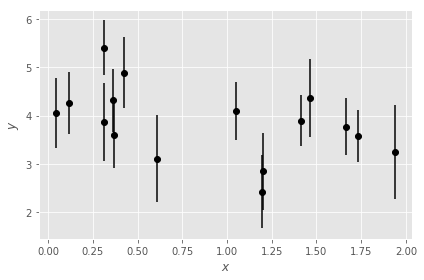

In [4]:
# evaluate the true model at the given x values
y = a_true*x + b_true

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = rnd.uniform(0.5, 1.0, size=n_data) # randomly generate uncertainty for each datum
y = rnd.normal(y, y_err) # re-sample y data with noise

plt.errorbar(x, y, y_err, linestyle='none', marker='o', color='k')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

__Now let's forget that we did that__. We know nothing about the model parameters, except that we think the true values of the data are well-described by a linear relation! We would like to measure the "best-fit" parameters of this model (for a straight line, the slope and intercept $(a,b)$) given the data above. In math, our model for the data $y$ is:
$$
\begin{align}
y &= f(x \,;\, a, b) + {\rm noise}\\
f(x \,;\, a, b) &= a\,x + b
\end{align}
$$

For a given set of parameters, $(a,b)$, we can evaluate our model $f(x \,;\, a, b)$ at a given $x$ location to compute the value of $y$ that we would expect in the absence of noise. For example, for the $n$th datum&mdash;that is $(x_n, y_n)$&mdash;and for a given set of parameter values $(a,b)$:

$$
\hat{y}_n = f(x_n \,;\, a, b)
$$

Now, we somehow want to search through all possible values of $a,b$ to find the "best" values, given the data, with some definition of "best." When we say this word, we are implying that we want to _optimize_ (find the maximum or minimum) some _objective function_ (a function that takes our data, our model, and returns a quantification of "best", usually as a scalar). Numerically, this scalar objective function can be any function (though you probably want it to be convex) and you will see different choices in practice. You have some leeway in this choice depending on whether your goal is _prediction_, _discovery_, or _data compression_. 

However, for _inference_&mdash;the typical use-case for us as scientists&mdash;you don't have this freedom: one of the conclusions of this talk is going to be that __you have no choice about what "best" means__! Before we get there, though, let's explore what seem like reasonable choices. 

Here are a few desirable features we'd like any objective function to have:

1. For a given set of parameters, we should compare our predicted values to the measured values and base our objective function on the differences
2. The scalar value should be dimensionless (the value of the objective function shouldn't care if we use kilometers vs. parsecs)
3. Data points that have larger errors should contribute less to the objective function (if a datum has a large offset from the predicted value, it shouldn't matter _if_ the datum has a large uncertainty)
4. Convexity

To meet these three criteria, whatever objective function we choose should operate on the (dimensionless) quantities:

$$
\chi_n = \frac{y_n - \hat{y}_n}{\sigma_n}
$$

i.e. the difference between our predicted values $\tilde{y}$ and the observed $y$ values, weighted by the inverse uncertainties $\sigma$. The uncertainties have the same units as the data, so this is a dimensionless quantity. It also has the nice property that, as we wanted, points with large uncertainties are _downweighted_ relative to points with small uncertainties. Here are some ideas for objective functions based on this scalar:

- __Weighted absolute deviation__: the sum of the absolute values

    $\sum_n^N \, \left|\chi_n\right|$
    
    
- __Weighted squared deviation__: the sum of the squares

    $\sum_n^N \, \chi_n^2$
    
    
- __Weighted absolute deviation to some power__ $p$: 

    $\sum_n^N \, \left|\chi_n\right|^p $
    
    
_(Note: To a statistician, $\chi^2$ is a distribution not a statistic...but physicists seem to use this terminology.)_

For simplicity, let's just compare two of these: the absolute deviation and the squared deviation. Both of these functions are convex and so we can pass them in to a naive optimizer to find the best parameters. Let's first implement the functions, and then pass them in to the default `scipy.optimize` function minimizer.

---

### Exercise 2: 

Implement the functions to compute the weighted deviations below

#### Solution:

In [5]:
def line_model(pars, x):
    """
    Evaluate a straight line model at the input x values.
    
    Parameters
    ----------
    pars : list, array
        This should be a length-2 array or list containing the 
        parameter values (a, b) for the (slope, intercept).
    x : numeric, list, array
        The coordinate values.
        
    Returns
    -------
    y : array
        The computed y values at each input x.
    """
    return pars[0]*np.array(x) + pars[1]

def weighted_absolute_deviation(pars, x, y, y_err):
    """
    Compute the weighted absolute deviation between the data 
    (x, y, y_err) and the model points computed with the input 
    parameters (pars).
    """
    chi = (y - line_model(pars, x)) / y_err
    return np.sum(np.abs(chi))

def weighted_squared_deviation(pars, x, y, y_err):
    """
    Compute the weighted squared deviation between the data 
    (x, y, y_err) and the model points computed with the input 
    parameters (pars).
    """
    chi = (y - line_model(pars, x)) / y_err
    return np.sum(chi**2)

Execute the cell below to verify if you did it correctly.

In [6]:
_pars = [1., -10.]
_x = np.arange(16)
_y = _x
_yerr = np.ones_like(_x)

truth = np.array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0., 1.,   2.,   3.,   4.,   5.])
assert np.allclose(line_model(_pars, _x), truth), 'Error in line_model() function!'
assert weighted_absolute_deviation(_pars, _x, _y, _yerr) == 160., 'Error in weighted_absolute_deviation() function!'
assert weighted_squared_deviation(_pars, _x, _y, _yerr) == 1600., 'Error in weighted_squared_deviation() function!'

We can demonstrate that these are convex (over some domain) by computing the objective function values over a grid of parameter values (a grid in $a, b$):

In [7]:
# make a 256x256 grid of parameter values centered on the true values
a_grid = np.linspace(a_true-2., a_true+2, 256)
b_grid = np.linspace(b_true-2., b_true+2, 256)
a_grid,b_grid = np.meshgrid(a_grid, b_grid)
ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel())).T

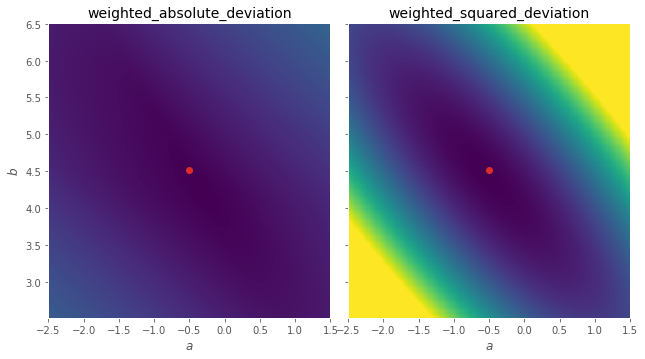

In [8]:
fig,axes = plt.subplots(1, 2, figsize=(9,5.1), sharex=True, sharey=True)

for i,func in enumerate([weighted_absolute_deviation, weighted_squared_deviation]):
    func_vals = np.zeros(ab_grid.shape[0])
    for j,pars in enumerate(ab_grid):
        func_vals[j] = func(pars, x, y, y_err)

    axes[i].pcolormesh(a_grid, b_grid, func_vals.reshape(a_grid.shape), 
                      # cmap='Blues', 
                       vmin=func_vals.min(), vmax=func_vals.min()+256) # arbitrary scale
    
    axes[i].set_xlabel('$a$')
    
    # plot the truth
    axes[i].plot(a_true, b_true, marker='o', zorder=10, color='#de2d26')
    axes[i].axis('tight')
    axes[i].set_title(func.__name__, fontsize=14)

axes[0].set_ylabel('$b$')

fig.tight_layout()

There are minima in both cases near the true values of the parameters (good), but the gradient of the function is clearly different (the color scales are the same in each panel above). Let's see what happens when we minimize these objective functions to get the best-fit parameter values:

In [9]:
from scipy.optimize import minimize

x0 = [1., 1.] # starting guess for the optimizer 

result_abs = minimize(weighted_absolute_deviation, x0=x0, 
                      args=(x, y, y_err), # passed to the weighted_*_deviation function after pars 
                      method='BFGS') # similar to Newton's method

result_sq = minimize(weighted_squared_deviation, x0=x0, 
                     args=(x, y, y_err), # passed to the weighted_*_deviation function after pars
                     method='BFGS')

best_pars_abs = result_abs.x
best_pars_sq = result_sq.x

Let's now plot our two best-fit lines over the data:

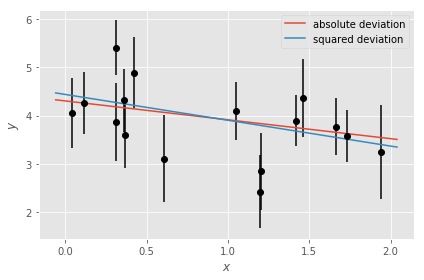

In [10]:
plt.errorbar(x, y, y_err, linestyle='none', marker='o', color='k')

x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 128)
plt.plot(x_grid, line_model(best_pars_abs, x_grid), 
         marker='', linestyle='-', label='absolute deviation')
plt.plot(x_grid, line_model(best_pars_sq, x_grid), 
         marker='', linestyle='-', label='squared deviation')

plt.xlabel('$x$')
plt.ylabel('$y$')

plt.legend(loc='best')
plt.tight_layout()

Well, by eye they both look reasonable! Are we done?! Not quite&mdash;how do we choose between the two?!

In order to pick between these two, or any of the arbitrary objective functions we could have chosen, we have to justify using one function over the others. In what follows, we'll justify optimizing the sum of the squared deviations (so-called "least-squares fitting") by thinking about the problem probabilistically, rather than procedurally.

___
## Least-Squares Fitting

Let's review the assumptions we made above in generating our data:

1. The data were generated by a straight line
2. Uncorrelated, _known_ Gaussian uncertainties in $y$ cause deviations between the data and predictions
3. The data points are independent
4. The $x$ data are known perfectly, or at least their uncertainties are _far smaller_ than the uncertainties in $y$

First off, these assumptions tell us that for each datum $(x_n, y_n)$ there is some true $y_{n,{\rm true}}$, and because of limitations in our observing process we can't observe the truth, but we know that the values we do observe will be Gaussian (Normal) distributed around the true value. _(Note: This assumption tends to be a good or at least a conservative approximation in practice, but there are certainly more complex situations when, e.g., you have asymmetric uncertainties, or error distributions with large tails!)_. In math:

$$
\begin{align}
p(y \,\mid\, y_{\rm true}) &= \mathcal{N}(y \,\mid\, y_{\rm true}, \sigma^2) \\
\mathcal{N}(y \,\mid\, y_{\rm true}, \sigma^2) &= (2\pi \sigma^2)^{-1/2} \, \exp\left(-\frac{1}{2} \frac{(y-y_{\rm true})^2}{\sigma^2} \right)
\end{align}
$$

This is the likelihood of observing a particular $y$ given the true $y_{\rm true}$. Note that in our model, all of the $y_{\rm true}$'s must lie on a line. It is also interesting that the argument of the normal distribution looks a lot like $\chi^2$!

What about considering two data points, $y_1$ and $y_2$? Now we need to write down the _joint_ probability

$$
p(y_1, y_2 \,\mid\, y_{1,{\rm true}}, \sigma_1, y_{2,{\rm true}}, \sigma_2)
$$

But, note that in assumption 3 above, we are assuming the data are independent. In that case, the random error in one point does not affect the random error in any other point, so the joint probability can be turned into a product:

$$
p(\{y_n\} \,\mid\, \{y_{n,{\rm true}}\}, \{\sigma_n\}) = \prod_n^N \, p(y_n \,\mid\, y_{n,{\rm true}}, \sigma_n)
$$

This is the full expression for the likelihood of the observed data given the true $y$ values. Recall that these true values, according to our assumptions, must lie on a line with some parameters, and we're trying to infer those parameters! We can compute a particular $y_{n,{\rm true}}$ using $x_n$ and a given set of model parameters $a, b$. With that in mind, we can write the likelihood instead as:

$$
p(\{y_n\} \,\mid\, a, b, \{x_n\}, \{\sigma_n\}) = \prod_n^N \, p(y_n \,\mid\, a, b, x_n, \sigma_n)
$$

So what are the "best" values of the parameters $a, b$? They are the ones that _maximize_ this likelihood! 

The product on the right of the likelihood is a product over exponentials (well, Gaussians), which can be annoying to deal with. But, maximizing the likelihood is equivalent to maximizing the _log_-likelihood -- so we can get rid of the product and all of those exponentials by taking the log of both sides:

$$
\begin{align}
\ln p(\{y_n\} \,\mid\, a, b, \{x_n\}, \{\sigma_n\}) &= \sum_n^N \, \ln\left[p(y_n \,\mid\, a, b, x_n, \sigma_n)\right] \\
&= \sum_n^N \ln \left[(2\pi \sigma_n^2)^{-1/2} \, 
    \exp\left(-\frac{1}{2} \frac{(y_n-(a\,x_n+b))^2}{\sigma_n^2} \right) \right] \\
&= -\frac{N}{2}\ln(2\pi) 
    - \frac{1}{2} \sum_n^N \left[\frac{(y_n-(a\,x_n+b))^2}{\sigma_n^2} + \ln{\sigma_n^2} \right]
\end{align}
$$

In this case, the uncertainties are known and constant, so to maximize this expression we only care that (abbreviating the likelihood as $\mathcal{L}$):

$$
\begin{align}
\ln \mathcal{L} &= - \frac{1}{2} \sum_n^N \left[\frac{(y_n-(a\,x_n+b))^2}{\sigma_n^2}\right] + {\rm const.} \\
&= - \frac{1}{2} \sum_n^N \, \chi_n^2 + {\rm const.} \\
\end{align}
$$

Apparently, _minimizing_ the sum of the weighted squared deviations is equivalent to _maximizing_ the (log) likelihood derived from thinking about the probability of the data! Above, we did that minimization numerically using an iterative solver. That's fine, but (a) it doesn't directly give us the uncertainties on the inferred model parameters, and (b) there is actually an analytic way to solve this problem using linear algebra that is generally _much_ faster!

__
## Least-squares / maximum likelihood with matrix calculus

Using linear algebra, we can simplify and generalize a lot of the expressions above. In what follows, all vectors are column vectors and are represented by lower-case bold symbols. Matrices are upper-case bold symbols.


We'll start by writing our model as a matrix equation. To do that, we need a way to, for a given set of parameters, compute the set of predicted $y$'s. This is done by defining the parameter vector, $\boldsymbol{\theta}$, and a matrix typically called the _design matrix_, $\boldsymbol{X}$:

$$
\boldsymbol{\theta} = \begin{bmatrix} b \\ a \end{bmatrix} \quad 
\boldsymbol{X} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{bmatrix}
$$

(note the order of the parameters!). With these definitions, the vector of predicted $y$ values is just

$$
\boldsymbol{y}_{\rm pred} = \boldsymbol{X} \, \boldsymbol{\theta}
$$

so the deviation vector between the prediction and the data is just $(\boldsymbol{y}-\boldsymbol{X} \, \boldsymbol{\theta})$ where

$$
\boldsymbol{y} = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{bmatrix}
$$

But how do we include the uncertainties? We'll pack the list of uncertainties (variances) into the trace of a 2D, $N \times N$ matrix called the _covariance matrix_. Because we are assuming the uncertainties are independent, the off-diagonal terms are all zero:

$$
\boldsymbol{\Sigma} = \begin{bmatrix} 
\sigma_1^2 & 0 & \dots & 0 \\ 
0 & \sigma_2^2 & \dots & 0 \\ 
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \sigma_N^2 
\end{bmatrix}
$$

With these matrices, we can write the expression for $\chi^2$ (and therefore the log-likelihood) very concisely:

$$
\begin{align}
\chi^2 &= \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)^\mathsf{T} \, 
    \boldsymbol{\Sigma}^{-1} \,
    \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right) \\
\ln\mathcal{L} &= -\frac{1}{2}\left[N\,\ln(2\pi) 
    + \ln|\boldsymbol{\Sigma}|
    + \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)^\mathsf{T} \, 
      \boldsymbol{\Sigma}^{-1} \,
      \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)
\right]
\end{align}
$$

In this form, the terms in the $\chi^2$ have a nice geometric interpretation: This looks like a distance between the data and the model computed with the metric $\boldsymbol{\Sigma}$.

If you solve for the optimum of the log-likelihood function (take the derivative with respect to $\boldsymbol{\theta}$ and set equal to 0), you find that:

$$
\newcommand{\trpo}[1]{{#1}^{\mathsf{T}}}
\newcommand{\bs}[1]{\boldsymbol{#1}}
\bs{\theta}_{\rm best} = \left[\trpo{\bs{X}} \, \bs{\Sigma}^{-1} \, \bs{X}\right]^{-1} \, 
    \trpo{\bs{X}} \, \bs{\Sigma}^{-1} \, \bs{y}
$$

Getting the best-fit parameters just requires a few simple linear algebra operations! As an added bonus, we also get the _uncertainties_ on the parameters. The $2\times2$ covariance matrix for the best-fit parameters is given by the matrix:

$$
\newcommand{\trpo}[1]{{#1}^{\mathsf{T}}}
\newcommand{\bs}[1]{\boldsymbol{#1}}
C = \left[\trpo{\bs{X}} \, \bs{\Sigma}^{-1} \, \bs{X}\right]^{-1}
$$

Instead of using an iterative optimizer like `scipy.optimize.minimize`, let's just write out the linear algebra explicitly and use `numpy.linalg` to solve this for us!

### Exercise 2: 

Implement the necessary linear algebra to solve for the best-fit parameters and the parameter covariance matrix, defined above. 

#### Solution:

In [11]:
# create matrices and vectors:

# learn this is a magical function - it makes exactly what we want for the design matrix
X = np.vander(x, N=2, increasing=True)
# OR:
# X = np.vstack((np.ones_like(x), x)).T

# you never want to do this in practice because the matrix will just be full of zeros!
#   that's a good way to waste all of your RAM on storing zeros...
Cov = np.diag(y_err**2)
Cinv = np.linalg.inv(Cov) # we need the inverse covariance matrix

X.shape, Cov.shape, y.shape

((16, 2), (16, 16), (16,))

In [12]:
# we can also get the parameter covariance matrix
pars_Cov = np.linalg.inv(X.T @ Cinv @ X)

# using the new Python matrix operator
best_pars_linalg = pars_Cov @ (X.T @ Cinv @ y)

Let's see how the parameter values compare to what we found using the numerical optimizer (we reversed the order for the linear algebra so we use `[::-1]` to reverse the array):

In [13]:
best_pars_sq - best_pars_linalg[::-1]

array([-4.47472637e-09, -3.78772125e-09])

In [14]:
# some tricks to get info we need to plot an ellipse, aligned with 
#    the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(pars_Cov)
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)

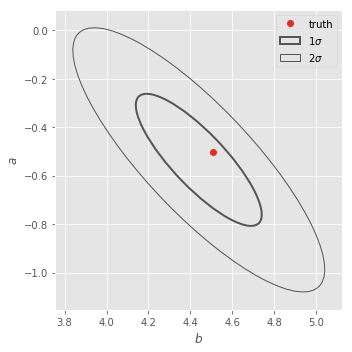

In [15]:
from matplotlib.patches import Ellipse

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,2]:
    ax.add_patch(Ellipse(best_pars_linalg, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax.plot(b_true, a_true, marker='o', zorder=10, linestyle='none',
        color='#de2d26', label='truth')

ax.set_xlabel('$b$')
ax.set_ylabel('$a$')
ax.legend(loc='best')

fig.tight_layout()

___
## The Bayesian approach

Let's review what we did so far. We found that standard weighted least squares fitting is a justified approach to estimating the best-fit parameters because it optimizes the likelihood of the data under the assumptions of our model; it optimizes a _justified scalar objective function_. We then fit our straight-line model to the data using and got back a point-estimate of the best parameters along with a covariance matrix describing the uncertainties in the parameters. This is the way of the _frequentist_. What we're going to do now is see what happens if we switch to a Bayesian methodology instead. While the two methods end up looking mathematically identical, there are fundamental philosophical differences that can lead to very different interpretations and implementations when models are more complex than the toy example we use above. 

As Bayesians, we aren't interested in a point-estimate of the best parameters, but rather we're interested in the inferred distribution of possible parameter values (the _posterior probability distribution function_ over parameters). So how do we write down or solve for this posterior pdf? Before we get to that, let's take a look at a fundamental equation of Bayesian statistics, [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes'_theorem), which we'll derive using the joint probability of $A$ and $B$ which are conditional on some other information $I$ that, right now, we don't care about. For example, $A$ could be the time it takes to get from here to NYC, $B$ could be the amount of traffic on the road, and $I$ could include the information that we're driving a car and not walking. Bayes' theorem as expressed below is not controversial -- Bayesians and Frequentists agree that this is just how joint and conditional probabilities work. We start by writing down the joint probability of $A$ and $B$, then factor it in two ways into conditional proabilities:

$$
p(A,B \,|\, I) = p(A\,|\,B, I)\,p(B\,|\, I) = p(B\,|\,A, I)\,p(A \,|\, I)
$$

Now we look at the right two expressions, and divide by one of the marginal probabilities to get:

$$
p(A\,|\,B, I) = \frac{p(B\,|\,A, I)\,p(A \,|\, I)}{p(B\,|\, I)}
$$

Ok, so that's all fine. Now let's replace $A$ and $B$ with variables that represent, from our example above, our data $D=(\{x_n\},\{y_n\},\{\sigma_n\})$ and our model parameters $\boldsymbol{\theta}$:

$$
p(\boldsymbol{\theta}\,|\,D, I) = \frac{p(D\,|\,\boldsymbol{\theta}, I)\,p(\boldsymbol{\theta} \,|\, I)}{p(D\,|\, I)}
$$

In just switching the meaning of the variables, this expression becomes controversial! Frequentists would object to the above for two main reasons:

1. The term on the left hand side is a probability over parameters given the data (the _posterior_ pdf) $p(\boldsymbol{\theta}\,|\,D, I)$. This is something that a frequentist would say cannot exist - there is only one true vector of parameters that we are trying to learn, not a distribution!
2. The right-most term in the numerator is a probability over parameters _with no dependence on the data_ (the _prior_ pdf). This encapsulates all of our prior knowledge about the parameters before we did the experiment and observed some data. This is perhaps the aspect of Bayesian inference that frequentists most disagree with. 

The differences above result from the fact that probability means something different to Frequentists and Bayesians. Bayesians think of probability as representing a _degree of belief_ about something, whereas a frequentist thinks of a probability as related to _limiting frequencies of occurrence_ in repeated trials or observations. This is a rich topic and I highly recommend reading [this series of blogposts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake Vanderplas to learn more. For now, let's put on Bayesian hats and take a look at the implications of the expression above.

(_It's good to rememeber that we're all friends. The differences are based on philosophy and so can lead to some heated discussions and debates, but remember we're all trying to do science -- we're on the same team!_)